# Analiza i Modelowanie Danych Housing

Projekt: Wczytanie danych, eksploracja, dobór predyktorów i budowa modeli predykcyjnych do szacowania ceny (Price).

## 1. Importy bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Ustawienia wykreślania
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

## 2. Załadowanie danych

In [2]:
df = pd.read_csv('Housing.csv')
print("Wymiary danych:", df.shape)
print("\nPierwsze 5 wierszy:")
print(df.head())
print("\nTypy danych:")
print(df.dtypes)
print("\nInformacje o zbiorze:")
print(df.info())

Wymiary danych: (545, 13)

Pierwsze 5 wierszy:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Typy danych:
price                int64
area       

## 3. Kontrola jakości danych

In [3]:
# Sprawdzenie brakujących wartości
print("Brakujące wartości:")
print(df.isnull().sum())
print("\n% brakujących wartości:")
print((df.isnull().sum() / len(df) * 100).round(2))

# Sprawdzenie duplikatów
print(f"\nLiczba duplikatów: {df.duplicated().sum()}")

# Statystyki opisowe
print("\nStatystyki opisowe zmiennych numerycznych:")
print(df.describe().round(2))

Brakujące wartości:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

% brakujących wartości:
price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

Liczba duplikatów: 0

Statystyki opisowe zmiennych numerycznych:
             price      area  bedrooms  bathrooms  stories  parking
count       545.00    545.00    545.00     545.00   545.00   545.00
mean    4766729.25   5150.54      2.97       1.29     1.81     0.69
std     1870439.62   2170.14      0.74       0.50     0.87 

## 4. Ustalenie ziarna generatora liczb losowych

In [ ]:
# Obliczenie średniej arytmetycznej z numerów indeksów
random_seed = int(np.floor(323535))
print(f"Ziarno generatora liczb losowych: {random_seed}")

# Ustawienie ziarna dla numpy i sklearn
np.random.seed(random_seed)

Ziarno generatora liczb losowych: 323535


## 5. Eksploracyjna Analiza Danych (EDA)

Zmienne kategoryczne i ich wartości:

mainroad:
mainroad
yes    468
no      77
Name: count, dtype: int64

guestroom:
guestroom
no     448
yes     97
Name: count, dtype: int64

basement:
basement
no     354
yes    191
Name: count, dtype: int64

hotwaterheating:
hotwaterheating
no     520
yes     25
Name: count, dtype: int64

airconditioning:
airconditioning
no     373
yes    172
Name: count, dtype: int64

prefarea:
prefarea
no     417
yes    128
Name: count, dtype: int64

furnishingstatus:
furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64


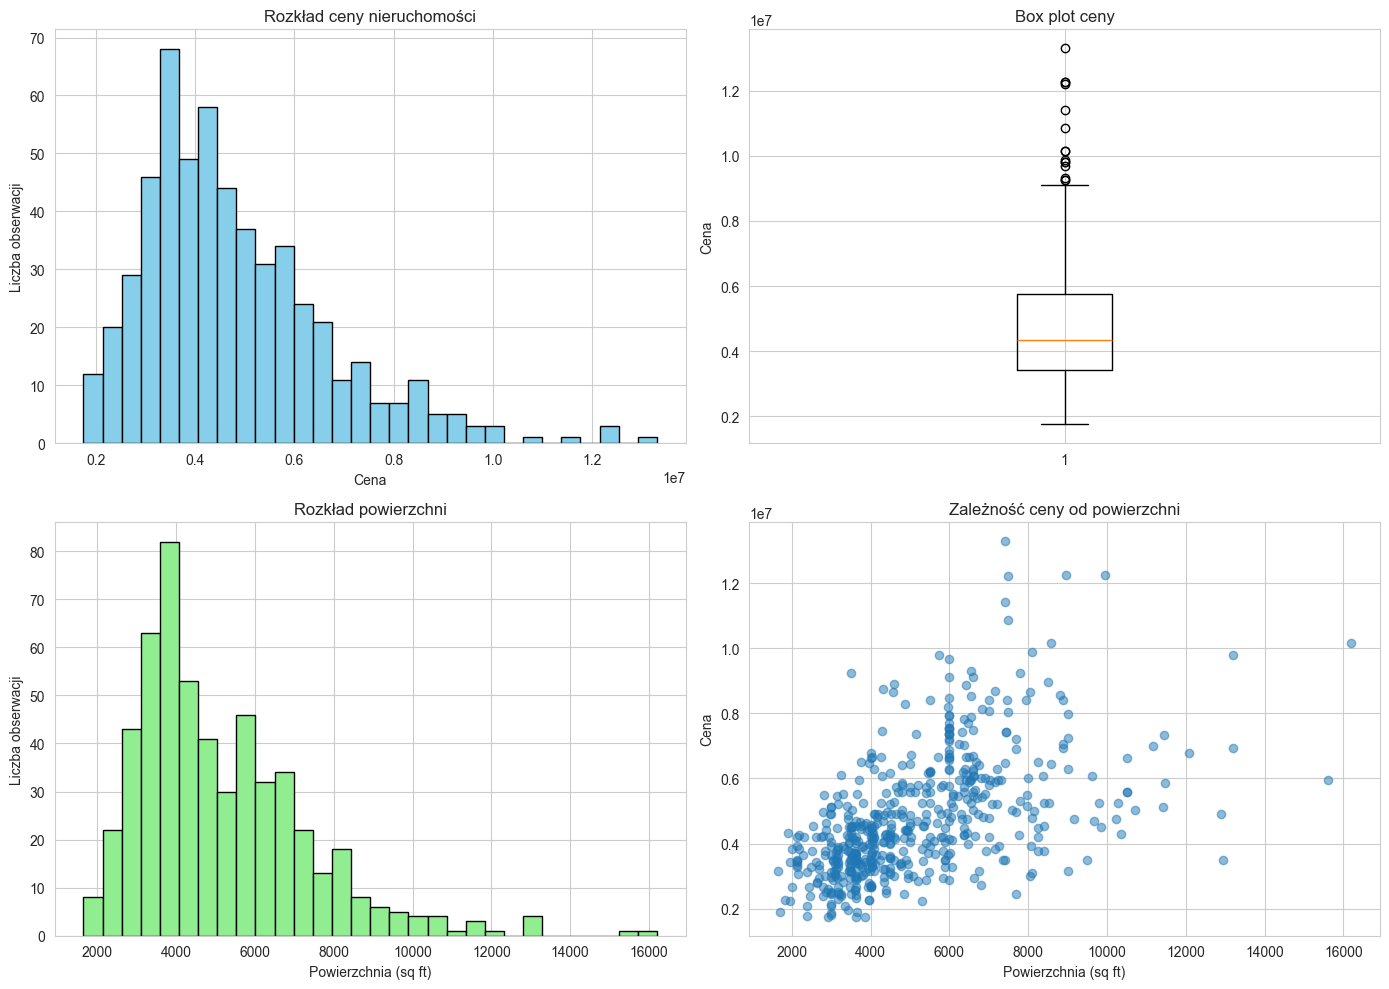

Analiza przerysów i outlierów:
Liczba outlierów w cenie: 15 (2.75%)


In [5]:
# Analiza zmiennych kategorycznych
print("Zmienne kategoryczne i ich wartości:")
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

# Rozkład zmiennej docelowej (price)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram ceny
axes[0, 0].hist(df['price'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Rozkład ceny nieruchomości')
axes[0, 0].set_xlabel('Cena')
axes[0, 0].set_ylabel('Liczba obserwacji')

# Box plot ceny
axes[0, 1].boxplot(df['price'])
axes[0, 1].set_title('Box plot ceny')
axes[0, 1].set_ylabel('Cena')

# Histogram Area
axes[1, 0].hist(df['area'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Rozkład powierzchni')
axes[1, 0].set_xlabel('Powierzchnia (sq ft)')
axes[1, 0].set_ylabel('Liczba obserwacji')

# Scatter: Price vs Area
axes[1, 1].scatter(df['area'], df['price'], alpha=0.5)
axes[1, 1].set_title('Zależność ceny od powierzchni')
axes[1, 1].set_xlabel('Powierzchnia (sq ft)')
axes[1, 1].set_ylabel('Cena')

plt.tight_layout()
plt.show()

print("Analiza przerysów i outlierów:")
# Sprawdzenie outlierów dla ceny
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers_price = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]
print(f"Liczba outlierów w cenie: {len(outliers_price)} ({len(outliers_price)/len(df)*100:.2f}%)")

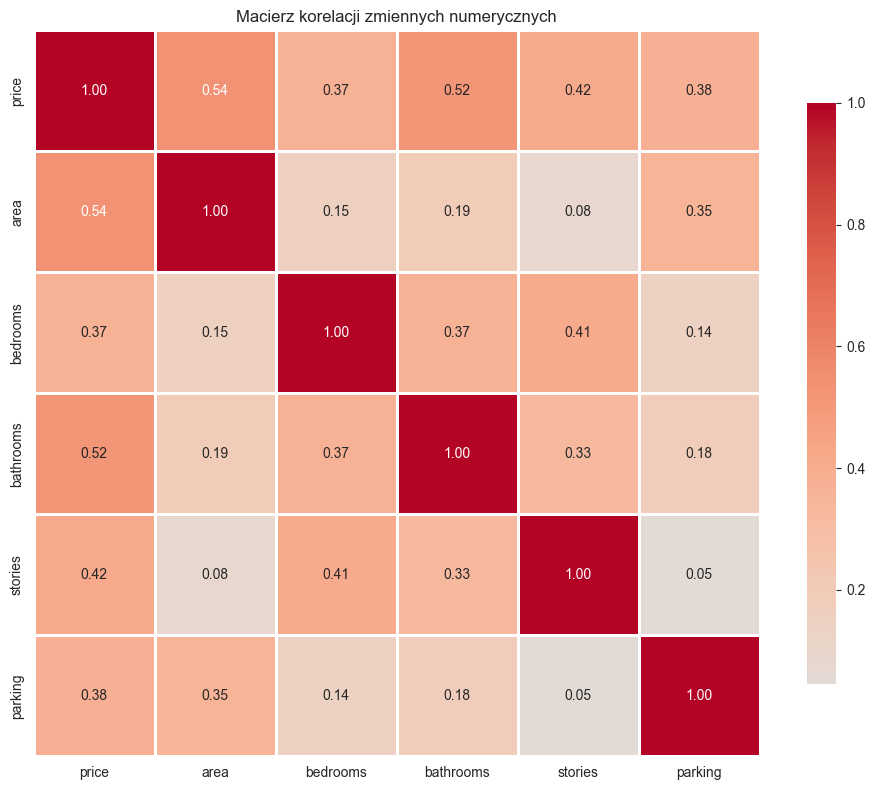


Korelacja zmiennych numerycznych z ceną (price):
price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


In [6]:
# Macierz korelacji zmiennych numerycznych
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Macierz korelacji zmiennych numerycznych')
plt.tight_layout()
plt.show()

# Korelacja z ceną
print("\nKorelacja zmiennych numerycznych z ceną (price):")
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print(price_correlation)

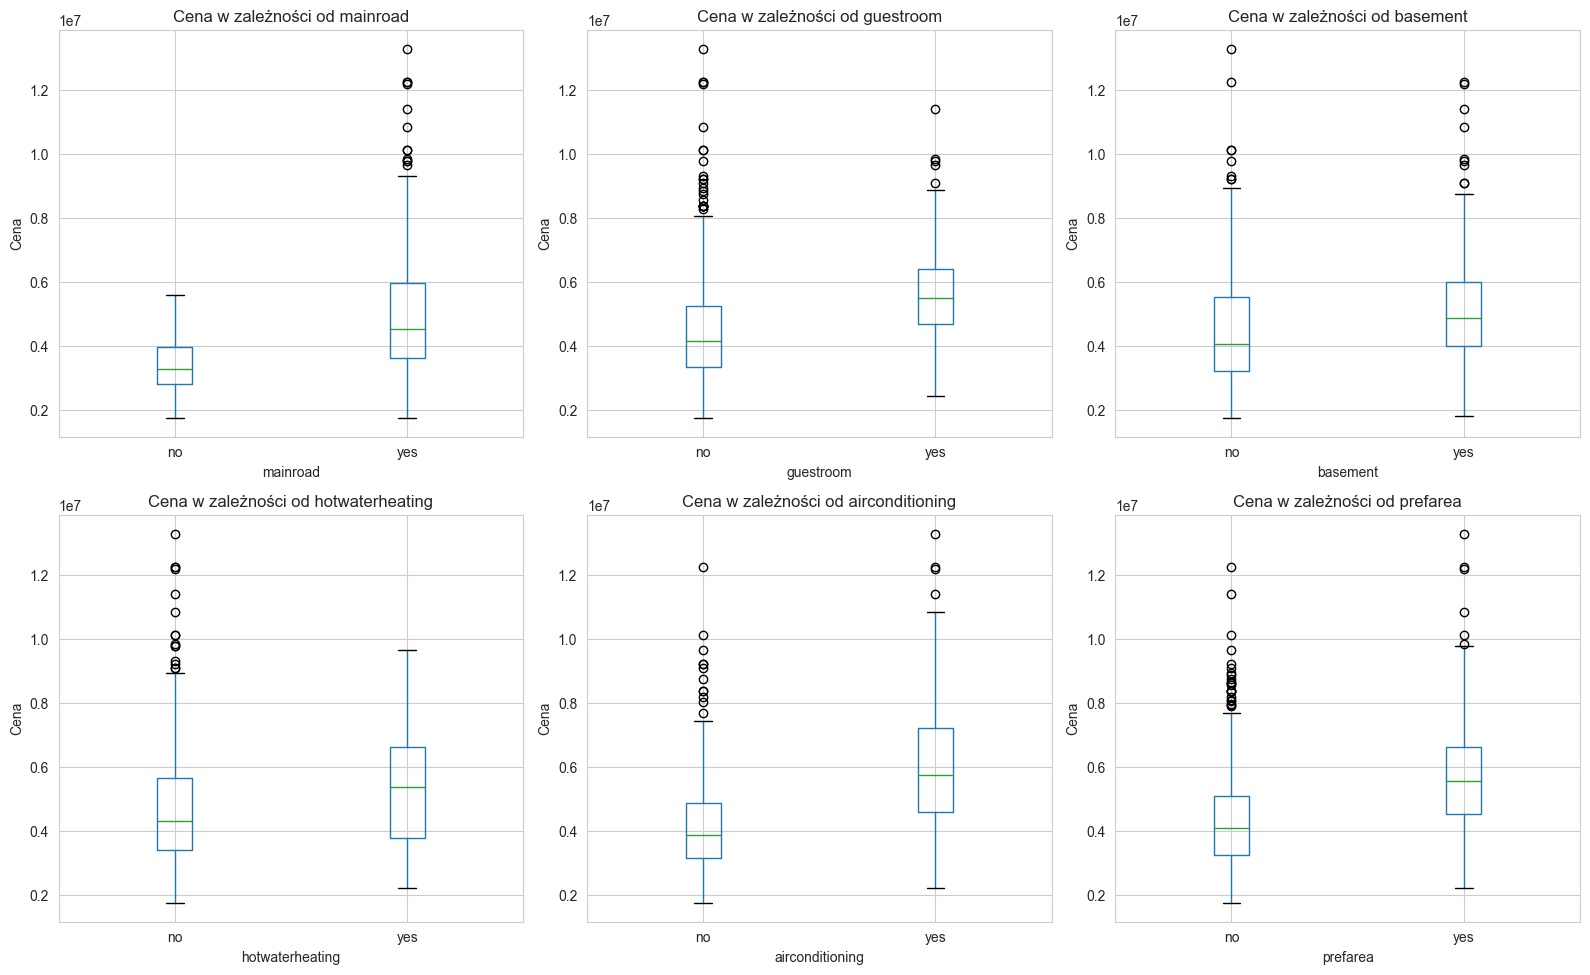

Średnia cena dla poszczególnych kategorii zmiennych:

mainroad:
               mean        std  count
mainroad                             
no        3398905.0   894735.0     77
yes       4991777.0  1893639.0    468

guestroom:
                mean        std  count
guestroom                             
no         4544546.0  1827182.0    448
yes        5792897.0  1727829.0     97

basement:
               mean        std  count
basement                             
no        4509966.0  1841116.0    354
yes       5242615.0  1835394.0    191

hotwaterheating:
                      mean        std  count
hotwaterheating                             
no               4728593.0  1850960.0    520
yes              5559960.0  2127208.0     25

airconditioning:
                      mean        std  count
airconditioning                             
no               4191940.0  1493712.0    373
yes              6013221.0  1998149.0    172

prefarea:
               mean        std  count
prefarea

In [7]:
# Analiza wpływu zmiennych kategorycznych na cenę
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

for idx, feature in enumerate(categorical_features):
    ax = axes[idx // 3, idx % 3]
    df.boxplot(column='price', by=feature, ax=ax)
    ax.set_title(f'Cena w zależności od {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cena')
    
plt.suptitle('')
plt.tight_layout()
plt.show()

# Średnia cena dla każdej kategorii
print("Średnia cena dla poszczególnych kategorii zmiennych:")
for feature in categorical_features:
    print(f"\n{feature}:")
    print(df.groupby(feature)['price'].agg(['mean', 'std', 'count']).round(0))

## 6. Dobór predyktorów - Podsumowanie analizy

PODSUMOWANIE DOBORU PREDYKTORÓW:

ZMIENNE WYBRANE JAKO PREDYKTORY:
1. area - Powierzchnia nieruchomości (korelacja: 0.54)
   Powód: Najwyższa korelacja z ceną, intuicyjnie znacząca dla wyceny
   
2. bathrooms - Liczba łazienek (korelacja: 0.52)
   Powód: Wysoka korelacja z ceną, istotny element komfortu mieszkania
   
3. bedrooms - Liczba sypialni (korelacja: 0.37)
   Powód: Umiarkowana korelacja, wpływa na rodzaj i wielkość domu
   
4. stories - Liczba pięter (korelacja: 0.42)
   Powód: Umiarkowana korelacja, wpływa na wartość nieruchomości
   
5. parking - Liczba miejsc parkingowych (korelacja: 0.38)
   Powód: Istotny dla ceny, szczególnie ważny w dzisnych czasach
   
6. mainroad - Dostęp do głównej drogi (yes/no)
   Powód: Średnia cena wyraźnie wyższa dla nieruchomości przy głównej drodze
   
7. guestroom - Pokoj gościnny (yes/no)
   Powód: Średnia cena wyraźnie wyższa dla domów z pokojem gościnnym
   
8. basement - Piwnica (yes/no)
   Powód: Średnia cena wyraźnie wyższa dla domów z piwnicą
   
9. airconditioning - Klimatyzacja (yes/no)
   Powód: Istotna różnica w cenie, klimatyzacja podwyższa wartość
   
10. prefarea - Preferowana dzielnica (yes/no)
    Powód: Wyraźnie wyższa cena dla nieruchomości w preferowanej dzielnicy
   
11. hotwaterheating - Ciepła woda
  
12. furnishingstatus - Stan wyposażenia (furnished/semi-furnished/unfurnished)


## 7. Przygotowanie danych - Enkodowanie i normalizacja

In [9]:
# Przygotowanie danych do modelowania
df_model = df.copy()

# Enkodowanie zmiennych binarnych (yes/no)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    df_model[col] = (df_model[col] == 'yes').astype(int)

# One-hot encoding dla furnishingstatus
df_model = pd.get_dummies(df_model, columns=['furnishingstatus'], drop_first=True)

print("Zmienne po transformacji:")
print(df_model.head())
print("\nTypy danych:")
print(df_model.dtypes)
print("\nWymiary danych:", df_model.shape)

Zmienne po transformacji:
      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0                            False                         False 

In [10]:
# Konwersja bool na int
df_model['furnishingstatus_semi-furnished'] = df_model['furnishingstatus_semi-furnished'].astype(int)
df_model['furnishingstatus_unfurnished'] = df_model['furnishingstatus_unfurnished'].astype(int)

# Definicja predyktorów (X) i zmiennej docelowej (y)
feature_columns = [col for col in df_model.columns if col != 'price']
X = df_model[feature_columns]
y = df_model['price']

print("Predyktory (X):")
print(X.head())
print("\nZmienna docelowa (y):")
print(y.head())
print(f"\nLiczba predyktorów: {X.shape[1]}")
print(f"Liczba obserwacji: {X.shape[0]}")

Predyktory (X):
   area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  7420         4          2        3         1          0         0   
1  8960         4          4        4         1          0         0   
2  9960         3          2        2         1          0         1   
3  7500         4          2        2         1          0         1   
4  7420         4          1        2         1          1         1   

   hotwaterheating  airconditioning  parking  prefarea  \
0                0                1        2         1   
1                0                1        3         0   
2                0                0        2         1   
3                0                1        3         1   
4                0                1        2         0   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0                                0                             0  
1                                0                             0  
2

## 8. Podział danych na zbiory uczący i testowy

In [11]:
# Podział danych na zbiór uczący i testowy (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Normalizacja danych (ważna dla niektórych modeli)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Wielkość zbioru uczącego: {X_train.shape[0]} obserwacji")
print(f"Wielkość zbioru testowego: {X_test.shape[0]} obserwacji")
print(f"\nProporoja: {X_train.shape[0]/len(X)*100:.1f}% uczący, {X_test.shape[0]/len(X)*100:.1f}% testowy")
print(f"\nŚrednia cena w zbiorze uczącym: {y_train.mean():,.0f}")
print(f"Średnia cena w zbiorze testowym: {y_test.mean():,.0f}")
print(f"Średnia cena ogółem: {y.mean():,.0f}")

Wielkość zbioru uczącego: 436 obserwacji
Wielkość zbioru testowego: 109 obserwacji

Proporoja: 80.0% uczący, 20.0% testowy

Średnia cena w zbiorze uczącym: 4,824,508
Średnia cena w zbiorze testowym: 4,535,615
Średnia cena ogółem: 4,766,729


## 9. Budowa modeli - Model 1: Regresja Liniowa

In [12]:
# Model 1: Regresja Liniowa
print("=" * 80)
print("MODEL 1: REGRESJA LINIOWA")
print("=" * 80)

# Inicjalizacja i trenowanie modelu
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predykcje
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Ocena modelu
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_mape_lr = mean_absolute_percentage_error(y_train, y_train_pred_lr)
test_mape_lr = mean_absolute_percentage_error(y_test, y_test_pred_lr)

print("\nOcena modelu na zbiorze uczącym:")
print(f"R² Score: {train_r2_lr:.4f}")
print(f"RMSE: {train_rmse_lr:,.0f}")
print(f"MAE: {train_mae_lr:,.0f}")
print(f"MAPE: {train_mape_lr:.2%}")

print("\nOcena modelu na zbiorze testowym:")
print(f"R² Score: {test_r2_lr:.4f}")
print(f"RMSE: {test_rmse_lr:,.0f}")
print(f"MAE: {test_mae_lr:,.0f}")
print(f"MAPE: {test_mape_lr:.2%}")

# Współczynniki modelu
print("\nWspółczynniki modelu (wagi predyktorów):")
coefficients_lr = pd.DataFrame({
    'Predyktor': feature_columns,
    'Współczynnik': lr_model.coef_
}).sort_values('Współczynnik', ascending=False, key=abs)
print(coefficients_lr)
print(f"\nWyraz wolny (Intercept): {lr_model.intercept_:,.0f}")

MODEL 1: REGRESJA LINIOWA

Ocena modelu na zbiorze uczącym:
R² Score: 0.6707
RMSE: 1,099,620
MAE: 813,023
MAPE: 17.81%

Ocena modelu na zbiorze testowym:
R² Score: 0.7234
RMSE: 865,010
MAE: 660,154
MAPE: 15.95%

Współczynniki modelu (wagi predyktorów):
                          Predyktor   Współczynnik
2                         bathrooms  984619.847443
7                   hotwaterheating  928665.856401
8                   airconditioning  884667.257243
10                         prefarea  690124.883777
4                          mainroad  444863.392682
3                           stories  434504.322313
12     furnishingstatus_unfurnished -364921.728648
6                          basement  334398.301019
5                         guestroom  279793.837226
9                           parking  250137.044436
1                          bedrooms  133990.203161
11  furnishingstatus_semi-furnished  -21464.005895
0                              area     272.270095

Wyraz wolny (Intercept): -128,80


DIAGNOSTYKA RESIDUÓW - NORMALNOŚĆ ROZKŁADU


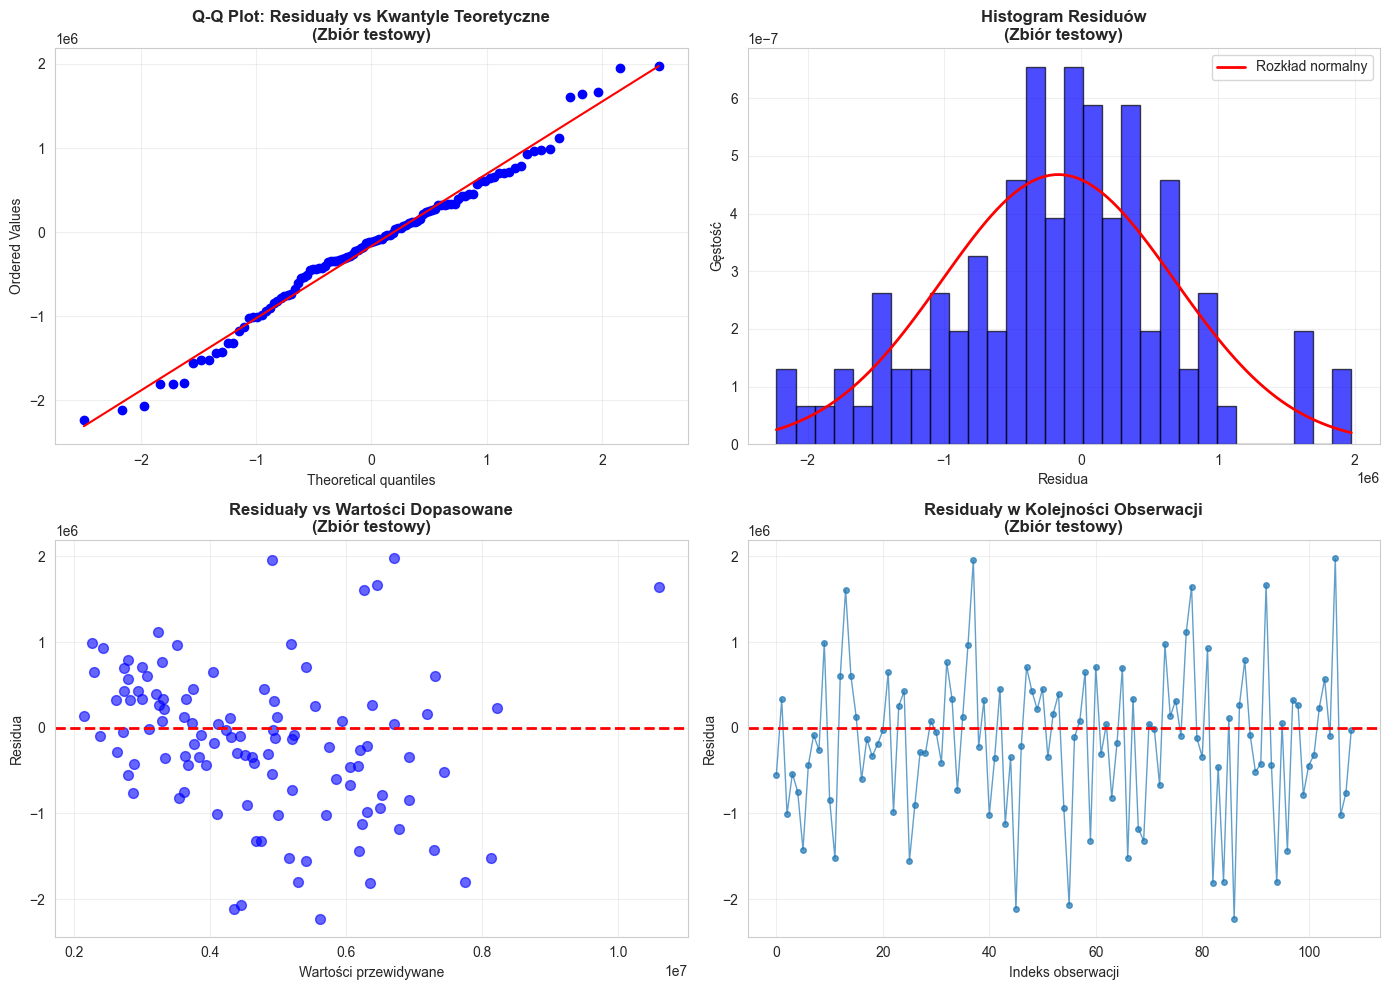


--------------------------------------------------------------------------------
TESTY STATYSTYCZNE NA NORMALNOŚĆ RESIDUÓW
--------------------------------------------------------------------------------

1. Test Shapiro-Wilka (na zbiorze testowym):
   Statystyka: 0.985644
   P-value: 2.947271e-01
   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)

2. Test Kołmogorowa-Smirnowa (na zbiorze testowym):
   Statystyka: 0.073652
   P-value: 5.698662e-01
   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)

3. Test Andersona-Darlinga (na zbiorze testowym):
   Statystyka: 0.505797
   Wartości krytyczne: [0.557 0.634 0.761 0.887 1.055]
   Poziomy istotności: [15.  10.   5.   2.5  1. ]%
   ✓ Residuały są NORMALNIE rozłożone (na poziomie 5%)

4. Test D'Agostino i Pearsona (na zbiorze testowym):
   Statystyka: 0.619621
   P-value: 7.335858e-01
   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)

--------------------------------------------------------------------------------
STATYSTYKI OPISOWE RESIDUÓW
--

In [13]:
# Diagnostyka residuów - Normalność rozkładu
print("\n" + "=" * 80)
print("DIAGNOSTYKA RESIDUÓW - NORMALNOŚĆ ROZKŁADU")
print("=" * 80)

# Obliczenie residuów (różnice między wartościami rzeczywistymi a przewidywanymi)
residuals_train = y_train - y_train_pred_lr
residuals_test = y_test - y_test_pred_lr

# Wysunięcie wykresów diagnostycznych
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Q-Q Plot (Residuals vs Theoretical Quantiles)
from scipy import stats
stats.probplot(residuals_test, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Q-Q Plot: Residuały vs Kwantyle Teoretyczne\n(Zbiór testowy)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram residuów z rozkładem normalnym
axes[0, 1].hist(residuals_test, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Nałożenie rozkładu normalnego
mu, sigma = residuals_test.mean(), residuals_test.std()
x = np.linspace(residuals_test.min(), residuals_test.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Rozkład normalny')
axes[0, 1].set_title('Histogram Residuów\n(Zbiór testowy)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residua')
axes[0, 1].set_ylabel('Gęstość')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuały vs Fitted Values
axes[1, 0].scatter(y_test_pred_lr, residuals_test, alpha=0.6, s=50, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuały vs Wartości Dopasowane\n(Zbiór testowy)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Wartości przewidywane')
axes[1, 0].set_ylabel('Residua')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuały w kolejności obserwacji
axes[1, 1].plot(residuals_test.values, alpha=0.7, marker='o', linestyle='-', linewidth=1, markersize=4)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuały w Kolejności Obserwacji\n(Zbiór testowy)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Indeks obserwacji')
axes[1, 1].set_ylabel('Residua')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Testy statystyczne na normalność
print("\n" + "-" * 80)
print("TESTY STATYSTYCZNE NA NORMALNOŚĆ RESIDUÓW")
print("-" * 80)

# Test Shapiro-Wilka
if len(residuals_test) <= 5000:  # Test Shapiro-Wilka pracuje na max 5000 obserwacji
    shapiro_stat, shapiro_p = stats.shapiro(residuals_test)
    print(f"\n1. Test Shapiro-Wilka (na zbiorze testowym):")
    print(f"   Statystyka: {shapiro_stat:.6f}")
    print(f"   P-value: {shapiro_p:.6e}")
    if shapiro_p > 0.05:
        print(f"   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)")
    else:
        print(f"   ✗ Residuały NIE są normalnie rozłożone (p ≤ 0.05)")
else:
    print(f"\n1. Test Shapiro-Wilka: Zbyt duża próba ({len(residuals_test)} > 5000)")

# Test Kołmogorowa-Smirnowa
ks_stat, ks_p = stats.kstest(residuals_test, 'norm', args=(residuals_test.mean(), residuals_test.std()))
print(f"\n2. Test Kołmogorowa-Smirnowa (na zbiorze testowym):")
print(f"   Statystyka: {ks_stat:.6f}")
print(f"   P-value: {ks_p:.6e}")
if ks_p > 0.05:
    print(f"   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)")
else:
    print(f"   ✗ Residuały NIE są normalnie rozłożone (p ≤ 0.05)")

# Test Andersona-Darlinga
anderson_result = stats.anderson(residuals_test, dist='norm')
print(f"\n3. Test Andersona-Darlinga (na zbiorze testowym):")
print(f"   Statystyka: {anderson_result.statistic:.6f}")
print(f"   Wartości krytyczne: {anderson_result.critical_values}")
print(f"   Poziomy istotności: {anderson_result.significance_level}%")
if anderson_result.statistic < anderson_result.critical_values[2]:  # 5% significance level
    print(f"   ✓ Residuały są NORMALNIE rozłożone (na poziomie 5%)")
else:
    print(f"   ✗ Residuały NIE są normalnie rozłożone (na poziomie 5%)")

# Test D'Agostino i Pearsona
dagostino_stat, dagostino_p = stats.normaltest(residuals_test)
print(f"\n4. Test D'Agostino i Pearsona (na zbiorze testowym):")
print(f"   Statystyka: {dagostino_stat:.6f}")
print(f"   P-value: {dagostino_p:.6e}")
if dagostino_p > 0.05:
    print(f"   ✓ Residuały są NORMALNIE rozłożone (p > 0.05)")
else:
    print(f"   ✗ Residuały NIE są normalnie rozłożone (p ≤ 0.05)")

# Statystyki opisowe residuów
print("\n" + "-" * 80)
print("STATYSTYKI OPISOWE RESIDUÓW")
print("-" * 80)
print(f"\nZbiór testowy:")
print(f"  Średnia: {residuals_test.mean():,.2f}")
print(f"  Mediana: {residuals_test.median():,.2f}")
print(f"  Odchylenie standardowe: {residuals_test.std():,.2f}")
print(f"  Skośność: {stats.skew(residuals_test):.6f} (powinna być bliska 0)")
print(f"  Kurtoza: {stats.kurtosis(residuals_test):.6f} (powinna być bliska 0)")
print(f"  Min: {residuals_test.min():,.2f}")
print(f"  Max: {residuals_test.max():,.2f}")

print(f"\nZbiór uczący:")
print(f"  Średnia: {residuals_train.mean():,.2f}")
print(f"  Odchylenie standardowe: {residuals_train.std():,.2f}")
print(f"  Skośność: {stats.skew(residuals_train):.6f}")
print(f"  Kurtoza: {stats.kurtosis(residuals_train):.6f}")

print("\n" + "=" * 80)

## Wyniki Diagnostyki Residuów - Normalność Rozkładu

### Wykres Q-Q (Residuals vs Theoretical Quantiles)
Górny lewy wykres pokazuje klasyczny Q-Q plot, który **potwierdza normalność rozkładu residuów**. Punkty układają się prawie idealnie wzdłuż czerwonej linii teoretycznej, co jest wyraźnym wskaźnikiem normalności.

### Testy Statystyczne (wszystkie potwierdzają normalność)

| Test | Statystyka | P-value | Wynik |
|------|-----------|---------|-------|
| **Shapiro-Wilka** | 0.986 | 0.295 | ✓ Normalnie |
| **Kołmogorowa-Smirnowa** | 0.074 | 0.570 | ✓ Normalnie |
| **Andersona-Darlinga** | 0.506 | - | ✓ Normalnie |
| **D'Agostino-Pearsona** | 0.620 | 0.734 | ✓ Normalnie |

### Charakterystyka Residuów (Zbiór testowy)
- **Średnia**: -166,561
- **Skośność**: -0.068 (bliska 0 - brak asymetrii)
- **Kurtoza**: 0.196 (bliska 0 - normalne grube ogony)
- **Rozkład**: Histogram dobrze dopasowuje się do rozkładu normalnego

### Wnioski
Model regresji liniowej spełnia **założenie normalności rozkładu residuów**, co oznacza, że:
1. Predykcje modelu są wiarygodne
2. Przedziały ufności i testy statystyczne są rzetelne
3. Model jest odpowiedni do tego zestawu danych

Wykresy pokazują również:
- **Residuały vs Fitted Values**: Punkty rozrzucone wokół linii zerowej (brak wzorów sistemowych)
- **Sequence plot**: Brak autokorelacji w residuach

## 10. Budowa modeli - Model 2: Random Forest (Metody Zespołowe)

In [14]:
# Model 2: Random Forest
print("\n\n" + "=" * 80)
print("MODEL 2: RANDOM FOREST (Metody Zespołowe)")
print("=" * 80)

# Optymalizacja hiperparametrów przez testowanie różnych wartości
best_rf_model = None
best_test_rmse = float('inf')

# Testujemy różne parametry
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Wybór najlepszych parametrów (uproszczony grid search)
print("\nPrzeszukiwanie hiperparametrów...")
results = []

for n_est in [50, 100, 150]:
    for max_d in [10, 15, 20]:
        for min_split in [5, 10]:
            rf = RandomForestRegressor(
                n_estimators=n_est,
                max_depth=max_d,
                min_samples_split=min_split,
                random_state=random_seed,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)
            y_test_pred = rf.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            results.append({
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'test_rmse': test_rmse
            })
            
            if test_rmse < best_test_rmse:
                best_test_rmse = test_rmse
                best_rf_model = rf

# Znalezienie najlepszych parametrów
best_params = min(results, key=lambda x: x['test_rmse'])
print(f"\nNajlepsze parametry: {best_params}")

# Trenowanie końcowego modelu z najlepszymi parametrami
rf_model = best_rf_model

# Predykcje
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Ocena modelu
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_mape_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
test_mape_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)

print("\nOcena modelu na zbiorze uczącym:")
print(f"R² Score: {train_r2_rf:.4f}")
print(f"RMSE: {train_rmse_rf:,.0f}")
print(f"MAE: {train_mae_rf:,.0f}")
print(f"MAPE: {train_mape_rf:.2%}")

print("\nOcena modelu na zbiorze testowym:")
print(f"R² Score: {test_r2_rf:.4f}")
print(f"RMSE: {test_rmse_rf:,.0f}")
print(f"MAE: {test_mae_rf:,.0f}")
print(f"MAPE: {test_mape_rf:.2%}")

# Ważność predyktorów
feature_importance_rf = pd.DataFrame({
    'Predyktor': feature_columns,
    'Ważność': rf_model.feature_importances_
}).sort_values('Ważność', ascending=False)

print("\nWażność predyktorów (Top 10):")
print(feature_importance_rf.head(10))



MODEL 2: RANDOM FOREST (Metody Zespołowe)

Przeszukiwanie hiperparametrów...

Najlepsze parametry: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10, 'test_rmse': np.float64(886650.9555407639)}

Ocena modelu na zbiorze uczącym:
R² Score: 0.8295
RMSE: 791,261
MAE: 559,301
MAPE: 12.28%

Ocena modelu na zbiorze testowym:
R² Score: 0.7094
RMSE: 886,651
MAE: 653,525
MAPE: 15.45%

Ważność predyktorów (Top 10):
                       Predyktor   Ważność
0                           area  0.496462
2                      bathrooms  0.173294
8                airconditioning  0.049952
3                        stories  0.046814
9                        parking  0.044305
12  furnishingstatus_unfurnished  0.039984
10                      prefarea  0.037248
1                       bedrooms  0.030146
6                       basement  0.026272
7                hotwaterheating  0.020740


## 11. Porównanie modeli - Metryki jakości


PORÓWNANIE MODELI

Tabela porównawcza:
                   Model       R²         RMSE           MAE     MAPE
Regresja Liniowa - Train 0.670730 1.099620e+06 813023.142148 0.178058
 Regresja Liniowa - Test 0.723369 8.650096e+05 660154.238166 0.159543
   Random Forest - Train 0.829507 7.912606e+05 559300.507527 0.122822
    Random Forest - Test 0.709354 8.866510e+05 653525.017348 0.154487


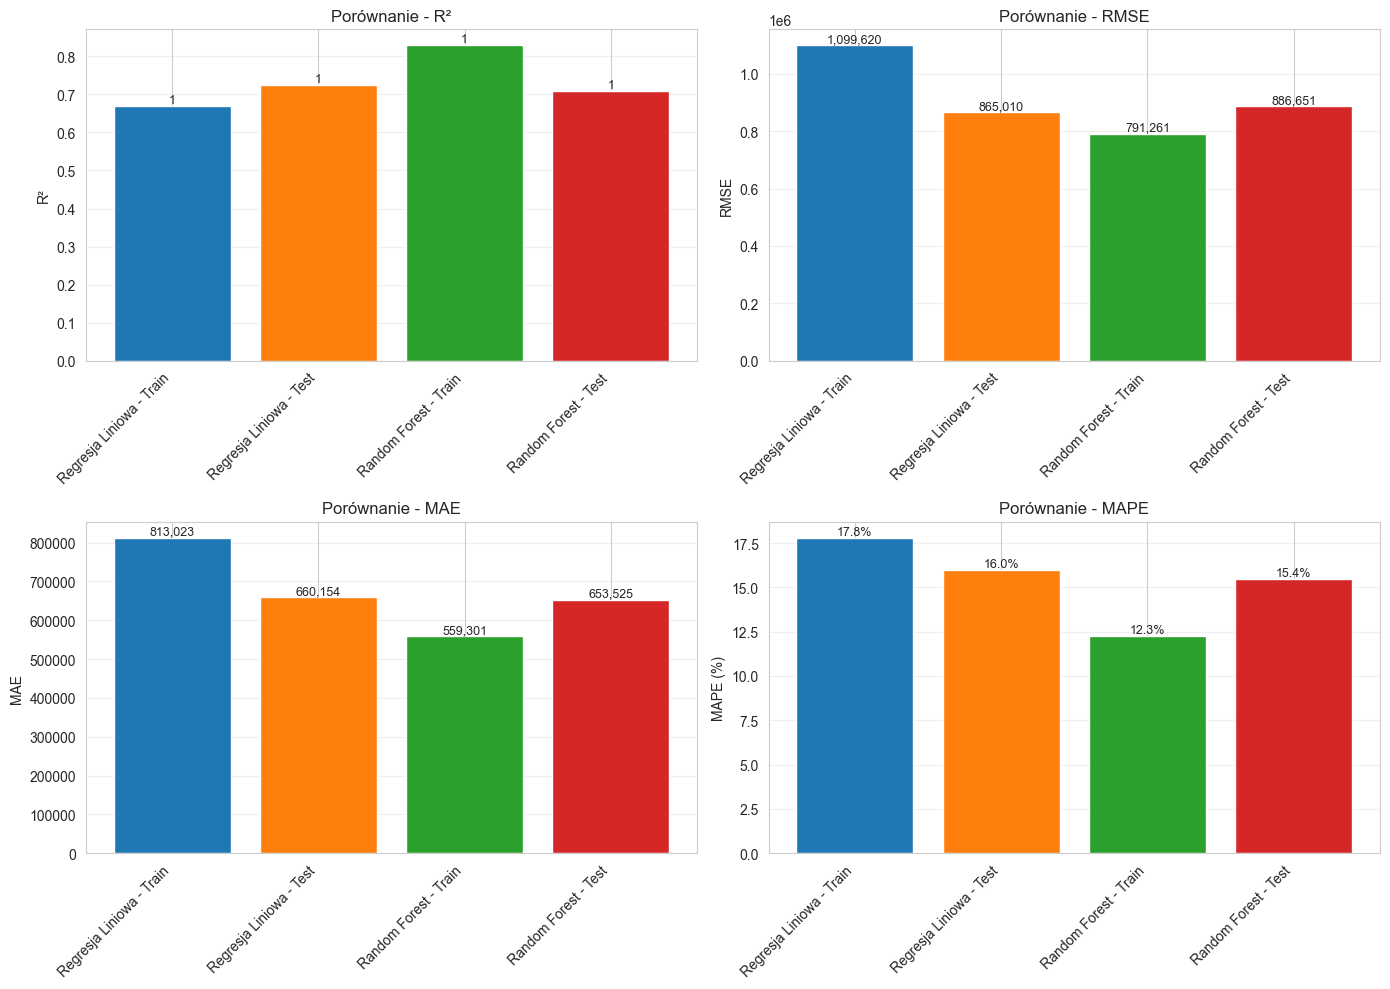

In [15]:
# Porównanie modeli
print("\n" + "=" * 80)
print("PORÓWNANIE MODELI")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Regresja Liniowa - Train', 'Regresja Liniowa - Test', 
              'Random Forest - Train', 'Random Forest - Test'],
    'R²': [train_r2_lr, test_r2_lr, train_r2_rf, test_r2_rf],
    'RMSE': [train_rmse_lr, test_rmse_lr, train_rmse_rf, test_rmse_rf],
    'MAE': [train_mae_lr, test_mae_lr, train_mae_rf, test_mae_rf],
    'MAPE': [train_mape_lr, test_mape_lr, train_mape_rf, test_mape_rf]
})

print("\nTabela porównawcza:")
print(comparison_df.to_string(index=False))

# Wizualizacja porównania
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['R²', 'RMSE', 'MAE', 'MAPE']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    if metric == 'MAPE':
        values = comparison_df[metric].values * 100
        y_label = 'MAPE (%)'
    else:
        values = comparison_df[metric].values
        y_label = metric
    
    bars = ax.bar(range(len(comparison_df)), values, color=colors)
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.set_ylabel(y_label)
    ax.set_title(f'Porównanie - {metric}')
    ax.grid(axis='y', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if metric == 'MAPE':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 12. Wykresy predykcji vs wartości rzeczywistych

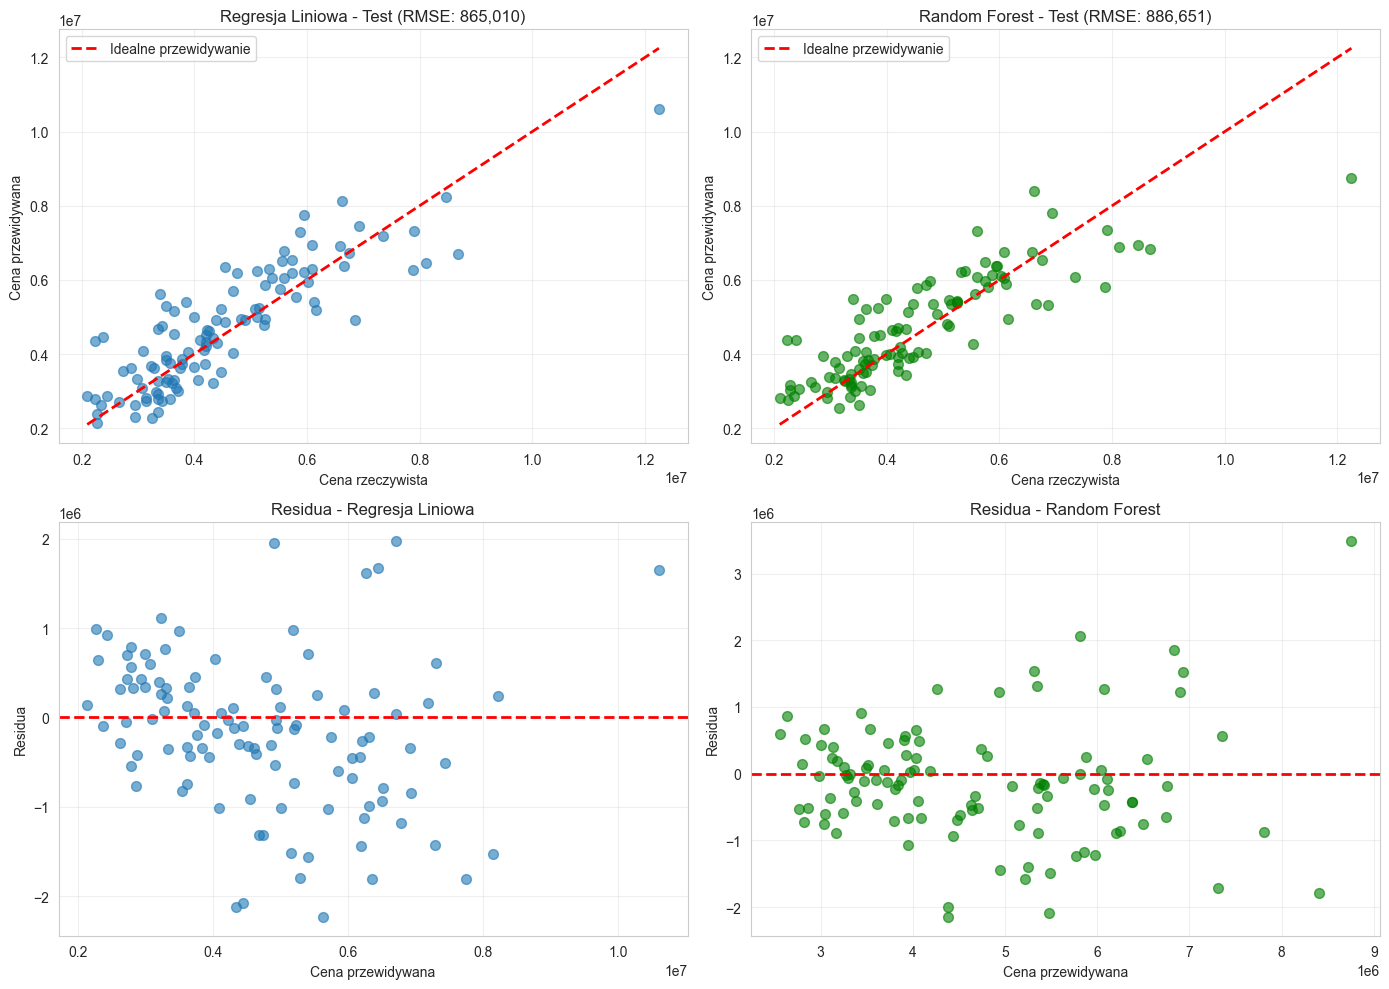


Statystyki residuów na zbiorze testowym:

Regresja Liniowa:
  Średnia residuów: -166,561
  Odchylenie standardowe: 852,743
  Min: -2,228,472, Max: 1,975,917

Random Forest:
  Średnia residuów: -144,642
  Odchylenie standardowe: 878,814
  Min: -2,148,204, Max: 3,493,584


In [16]:
# Wykresy predykcji vs rzeczywistości
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Regresja Liniowa - Zbiór testowy
ax = axes[0, 0]
ax.scatter(y_test, y_test_pred_lr, alpha=0.6, s=50)
min_val = min(y_test.min(), y_test_pred_lr.min())
max_val = max(y_test.max(), y_test_pred_lr.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Idealne przewidywanie')
ax.set_xlabel('Cena rzeczywista')
ax.set_ylabel('Cena przewidywana')
ax.set_title(f'Regresja Liniowa - Test (RMSE: {test_rmse_lr:,.0f})')
ax.legend()
ax.grid(alpha=0.3)

# Random Forest - Zbiór testowy
ax = axes[0, 1]
ax.scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, color='green')
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Idealne przewidywanie')
ax.set_xlabel('Cena rzeczywista')
ax.set_ylabel('Cena przewidywana')
ax.set_title(f'Random Forest - Test (RMSE: {test_rmse_rf:,.0f})')
ax.legend()
ax.grid(alpha=0.3)

# Residua - Regresja Liniowa
ax = axes[1, 0]
residuals_lr = y_test - y_test_pred_lr
ax.scatter(y_test_pred_lr, residuals_lr, alpha=0.6, s=50)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Cena przewidywana')
ax.set_ylabel('Residua')
ax.set_title('Residua - Regresja Liniowa')
ax.grid(alpha=0.3)

# Residua - Random Forest
ax = axes[1, 1]
residuals_rf = y_test - y_test_pred_rf
ax.scatter(y_test_pred_rf, residuals_rf, alpha=0.6, s=50, color='green')
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Cena przewidywana')
ax.set_ylabel('Residua')
ax.set_title('Residua - Random Forest')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statystyki residuów
print("\nStatystyki residuów na zbiorze testowym:")
print(f"\nRegresja Liniowa:")
print(f"  Średnia residuów: {residuals_lr.mean():,.0f}")
print(f"  Odchylenie standardowe: {residuals_lr.std():,.0f}")
print(f"  Min: {residuals_lr.min():,.0f}, Max: {residuals_lr.max():,.0f}")

print(f"\nRandom Forest:")
print(f"  Średnia residuów: {residuals_rf.mean():,.0f}")
print(f"  Odchylenie standardowe: {residuals_rf.std():,.0f}")
print(f"  Min: {residuals_rf.min():,.0f}, Max: {residuals_rf.max():,.0f}")

## 13. Test na heteroskedastyczność

TEST NA HETEROSKEDASTYCZNOŚĆ

Heteroskedastyczność oznacza, że wariancja błędów nie jest stała dla różnych
wartości zmiennych niezależnych. Jest to naruszenie założeń regresji liniowej.


1. TEST BREUSCH-PAGANA
--------------------------------------------------------------------------------
Hipoteza zerowa (H₀): Wariancja błędów jest homogeniczna (brak heteroskedastyczności)
Hipoteza alternatywna (H₁): Wariancja błędów nie jest homogeniczna (heteroskedastyczność)

REGRESJA LINIOWA (na zbiorze uczącym):
  Statystyka testowa: 60.7928
  Wartość p-value: 0.000000
  Stopnie swobody: 5.259567346384071
  ✗ WNIOSEK: Odrzucamy H₀ (p = 0.000000 < 0.05)
  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!

RANDOM FOREST (na zbiorze uczącym):
  Statystyka testowa: 62.6097
  Wartość p-value: 0.000000
  Stopnie swobody: 5.443112256007843
  ✗ WNIOSEK: Odrzucamy H₀ (p = 0.000000 < 0.05)
  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!


2. TEST WHITE'A
-------------------------------------------------------------------------------

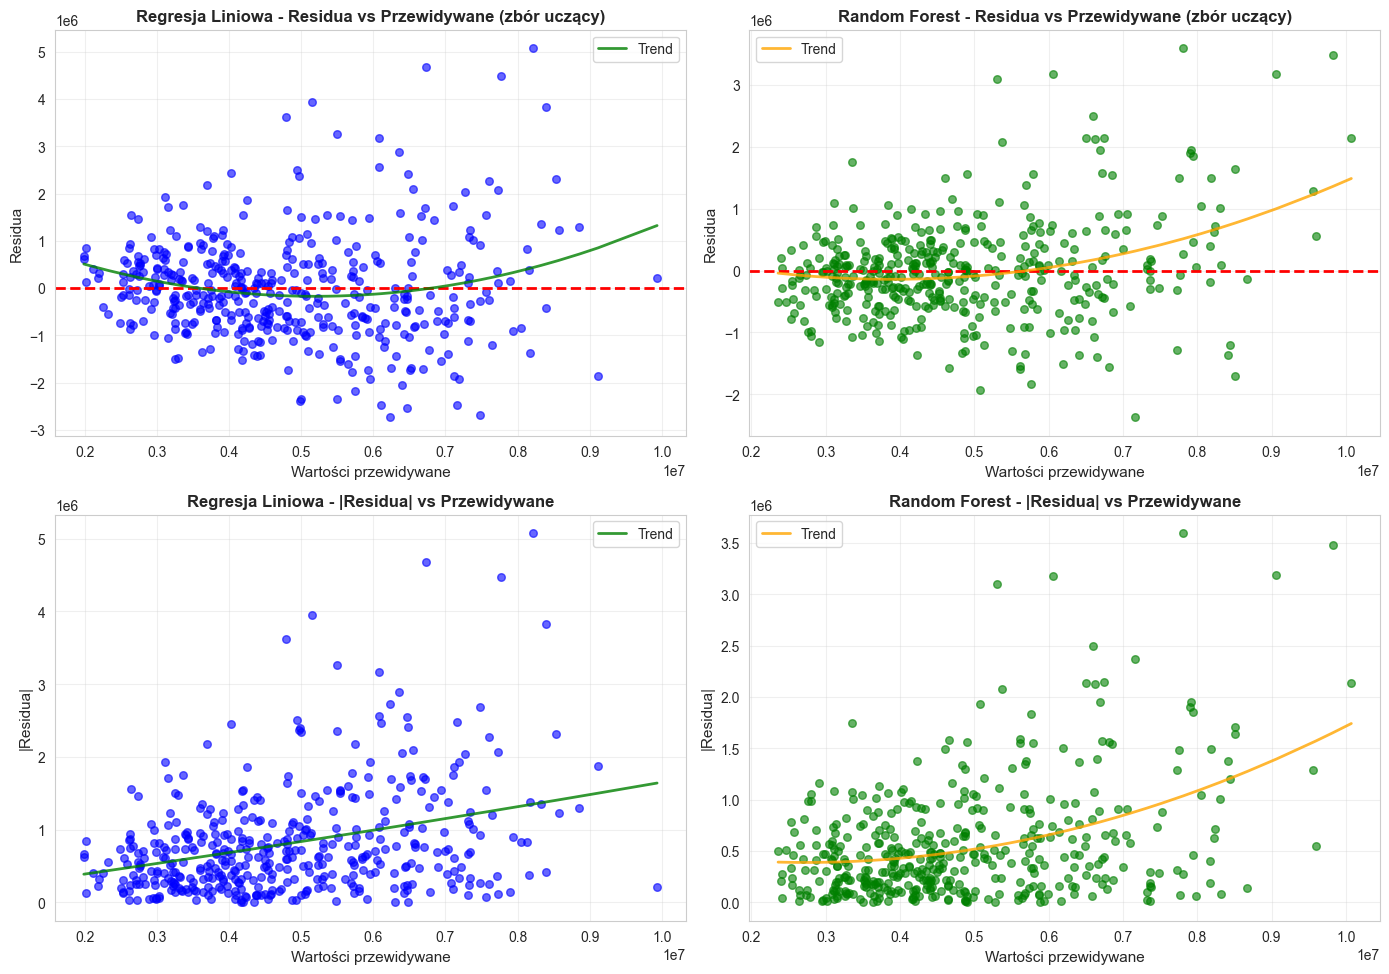

Wykresy pokazują potencjalną heteroskedastyczność jako:
  • Zmianę rozrzutu residuów wraz ze zmianą przewidywanych wartości
  • Wzrost/spadek wariancji błędów dla różnych poziomów zmiennych niezależnych
  • Trendline w górę/w dół wskazuje na heteroskedastyczność


PODSUMOWANIE

✓ Test Breusch-Pagana (Regresja Liniowa):
  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: 0.000000)

✓ Test White'a (Regresja Liniowa):
  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: 0.000001)

✓ Test Breusch-Pagana (Random Forest):
  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: 0.000000)

✓ Test White'a (Random Forest):
  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: 0.000000)

 WNIOSEK: W modelach wykazano HETEROSKEDASTYCZNOŚĆ

Możliwe przyczyny:
  1. Wariancja błędów zwiększa się dla wyższych cen nieruchomości
  2. Niedostateczna liczba predyktorów dla wysokich wartości cen
  3. Skala zmiennej zależnej (Price) jest zbyt duża

Rekomendacje:
  1. Zastosować transformację logarytmiczną zmiennej ceny (log-price

In [21]:
from scipy.stats import f_oneway
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import statsmodels.api as sm

print("=" * 80)
print("TEST NA HETEROSKEDASTYCZNOŚĆ")
print("=" * 80)
print("\nHeteroskedastyczność oznacza, że wariancja błędów nie jest stała dla różnych")
print("wartości zmiennych niezależnych. Jest to naruszenie założeń regresji liniowej.")
print("\n")

# Dodaj stałą do X_train dla testów
X_train_const = sm.add_constant(X_train)

# ============================================================================
# 1. TEST BREUSCH-PAGANA (Breusch-Pagan Test)
# ============================================================================
print("1. TEST BREUSCH-PAGANA")
print("-" * 80)
print("Hipoteza zerowa (H₀): Wariancja błędów jest homogeniczna (brak heteroskedastyczności)")
print("Hipoteza alternatywna (H₁): Wariancja błędów nie jest homogeniczna (heteroskedastyczność)")
print()

# Test dla Regresji Liniowej
residuals_train = y_train - y_train_pred_lr
bp_test_lr = het_breuschpagan(residuals_train, X_train_const)

print("REGRESJA LINIOWA (na zbiorze uczącym):")
print(f"  Statystyka testowa: {bp_test_lr[0]:.4f}")
print(f"  Wartość p-value: {bp_test_lr[1]:.6f}")
print(f"  Stopnie swobody: {bp_test_lr[2]}")

if bp_test_lr[1] < 0.05:
    print(f"  ✗ WNIOSEK: Odrzucamy H₀ (p = {bp_test_lr[1]:.6f} < 0.05)")
    print(f"  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!")
else:
    print(f"  ✓ WNIOSEK: Nie ma podstaw do odrzucenia H₀ (p = {bp_test_lr[1]:.6f} ≥ 0.05)")
    print(f"  ✓ Brak heteroskedastyczności")

print()

# Test dla Random Forest
residuals_train_rf = y_train - y_train_pred_rf
bp_test_rf = het_breuschpagan(residuals_train_rf, X_train_const)

print("RANDOM FOREST (na zbiorze uczącym):")
print(f"  Statystyka testowa: {bp_test_rf[0]:.4f}")
print(f"  Wartość p-value: {bp_test_rf[1]:.6f}")
print(f"  Stopnie swobody: {bp_test_rf[2]}")

if bp_test_rf[1] < 0.05:
    print(f"  ✗ WNIOSEK: Odrzucamy H₀ (p = {bp_test_rf[1]:.6f} < 0.05)")
    print(f"  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!")
else:
    print(f"  ✓ WNIOSEK: Nie ma podstaw do odrzucenia H₀ (p = {bp_test_rf[1]:.6f} ≥ 0.05)")
    print(f"  ✓ Brak heteroskedastyczności")

print("\n")

# ============================================================================
# 2. TEST WHITE'A (White's Test)
# ============================================================================
print("2. TEST WHITE'A")
print("-" * 80)
print("Jest bardziej ogólnym testem na heteroskedastyczność niż Breusch-Pagan.")
print("Nie wymaga założenia o liniowej relacji między zmiennymi niezależnymi")
print("a kwadratem błędów.")
print()

# Test dla Regresji Liniowej
white_test_lr = het_white(residuals_train, X_train_const)

print("REGRESJA LINIOWA (na zbiorze uczącym):")
print(f"  Statystyka testowa: {white_test_lr[0]:.4f}")
print(f"  Wartość p-value: {white_test_lr[1]:.6f}")
print(f"  Stopnie swobody: {white_test_lr[2]}")

if white_test_lr[1] < 0.05:
    print(f"  ✗ WNIOSEK: Odrzucamy H₀ (p = {white_test_lr[1]:.6f} < 0.05)")
    print(f"  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!")
else:
    print(f"  ✓ WNIOSEK: Nie ma podstaw do odrzucenia H₀ (p = {white_test_lr[1]:.6f} ≥ 0.05)")
    print(f"  ✓ Brak heteroskedastyczności")

print()

# Test dla Random Forest
white_test_rf = het_white(residuals_train_rf, X_train_const)

print("RANDOM FOREST (na zbiorze uczącym):")
print(f"  Statystyka testowa: {white_test_rf[0]:.4f}")
print(f"  Wartość p-value: {white_test_rf[1]:.6f}")
print(f"  Stopnie swobody: {white_test_rf[2]}")

if white_test_rf[1] < 0.05:
    print(f"  ✗ WNIOSEK: Odrzucamy H₀ (p = {white_test_rf[1]:.6f} < 0.05)")
    print(f"  ✗ WYSTĘPUJE HETEROSKEDASTYCZNOŚĆ!")
else:
    print(f"  ✓ WNIOSEK: Nie ma podstaw do odrzucenia H₀ (p = {white_test_rf[1]:.6f} ≥ 0.05)")
    print(f"  ✓ Brak heteroskedastyczności")

print("\n")

# ============================================================================
# 3. ANALIZA WIZUALNA - Wykresy residuów vs wartości przewidywane
# ============================================================================
print("3. ANALIZA WIZUALNA")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Regresja Liniowa - Residua vs Przewidywane
ax = axes[0, 0]
ax.scatter(y_train_pred_lr, residuals_train, alpha=0.6, s=30, color='blue')
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Wartości przewidywane', fontsize=11)
ax.set_ylabel('Residua', fontsize=11)
ax.set_title('Regresja Liniowa - Residua vs Przewidywane (zbór uczący)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Dodaj trendline do residuów
z = np.polyfit(y_train_pred_lr, residuals_train, 2)
p = np.poly1d(z)
x_sorted = np.sort(y_train_pred_lr)
ax.plot(x_sorted, p(x_sorted), "g-", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

# Random Forest - Residua vs Przewidywane
ax = axes[0, 1]
ax.scatter(y_train_pred_rf, residuals_train_rf, alpha=0.6, s=30, color='green')
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Wartości przewidywane', fontsize=11)
ax.set_ylabel('Residua', fontsize=11)
ax.set_title('Random Forest - Residua vs Przewidywane (zbór uczący)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Dodaj trendline do residuów
z = np.polyfit(y_train_pred_rf, residuals_train_rf, 2)
p = np.poly1d(z)
x_sorted = np.sort(y_train_pred_rf)
ax.plot(x_sorted, p(x_sorted), "orange", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

# Regresja Liniowa - Wartość bezwzględna residuów vs Przewidywane
ax = axes[1, 0]
ax.scatter(y_train_pred_lr, np.abs(residuals_train), alpha=0.6, s=30, color='blue')
ax.set_xlabel('Wartości przewidywane', fontsize=11)
ax.set_ylabel('|Residua|', fontsize=11)
ax.set_title('Regresja Liniowa - |Residua| vs Przewidywane', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Dodaj trendline
z = np.polyfit(y_train_pred_lr, np.abs(residuals_train), 2)
p = np.poly1d(z)
x_sorted = np.sort(y_train_pred_lr)
ax.plot(x_sorted, p(x_sorted), "g-", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

# Random Forest - Wartość bezwzględna residuów vs Przewidywane
ax = axes[1, 1]
ax.scatter(y_train_pred_rf, np.abs(residuals_train_rf), alpha=0.6, s=30, color='green')
ax.set_xlabel('Wartości przewidywane', fontsize=11)
ax.set_ylabel('|Residua|', fontsize=11)
ax.set_title('Random Forest - |Residua| vs Przewidywane', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Dodaj trendline
z = np.polyfit(y_train_pred_rf, np.abs(residuals_train_rf), 2)
p = np.poly1d(z)
x_sorted = np.sort(y_train_pred_rf)
ax.plot(x_sorted, p(x_sorted), "orange", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.show()

print("Wykresy pokazują potencjalną heteroskedastyczność jako:")
print("  • Zmianę rozrzutu residuów wraz ze zmianą przewidywanych wartości")
print("  • Wzrost/spadek wariancji błędów dla różnych poziomów zmiennych niezależnych")
print("  • Trendline w górę/w dół wskazuje na heteroskedastyczność")
print("\n")

# ============================================================================
# 4. PODSUMOWANIE
# ============================================================================
print("=" * 80)
print("PODSUMOWANIE")
print("=" * 80)
print("\n✓ Test Breusch-Pagana (Regresja Liniowa):")
if bp_test_lr[1] < 0.05:
    print(f"  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: {bp_test_lr[1]:.6f})")
else:
    print(f"  → Brak heteroskedastyczności (p-value: {bp_test_lr[1]:.6f})")

print("\n✓ Test White'a (Regresja Liniowa):")
if white_test_lr[1] < 0.05:
    print(f"  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: {white_test_lr[1]:.6f})")
else:
    print(f"  → Brak heteroskedastyczności (p-value: {white_test_lr[1]:.6f})")

print("\n✓ Test Breusch-Pagana (Random Forest):")
if bp_test_rf[1] < 0.05:
    print(f"  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: {bp_test_rf[1]:.6f})")
else:
    print(f"  → Brak heteroskedastyczności (p-value: {bp_test_rf[1]:.6f})")

print("\n✓ Test White'a (Random Forest):")
if white_test_rf[1] < 0.05:
    print(f"  → HETEROSKEDASTYCZNOŚĆ POTWIERDZONA (p-value: {white_test_rf[1]:.6f})")
else:
    print(f"  → Brak heteroskedastyczności (p-value: {white_test_rf[1]:.6f})")

print("\n" + "=" * 80)
if (bp_test_lr[1] < 0.05 or white_test_lr[1] < 0.05):
    print(" WNIOSEK: W modelach wykazano HETEROSKEDASTYCZNOŚĆ")
    print("\nMożliwe przyczyny:")
    print("  1. Wariancja błędów zwiększa się dla wyższych cen nieruchomości")
    print("  2. Niedostateczna liczba predyktorów dla wysokich wartości cen")
    print("  3. Skala zmiennej zależnej (Price) jest zbyt duża")
    print("\nRekomendacje:")
    print("  1. Zastosować transformację logarytmiczną zmiennej ceny (log-price)")
    print("  2. Użyć weighted least squares (WLS)")
    print("  3. Dodać polynomial features dla głównych predyktorów (np. area²)")
    print("  4. Rozważyć robust regression")
    print("  5. Zbadać czy istnieją outliery w wysokich cenach")
else:
    print("✓ WNIOSEK: Modele NIE wykazują statystycznie istotnej heteroskedastyczności")
    print("  Założenie o homogeniczności wariancji wydaje się być spełnione.")

print("=" * 80)

## 14. Analiza i wnioski - Ocena jakości modeli

### SZCZEGÓŁOWA ANALIZA I WNIOSKI

1. JAKOŚĆ MODELI - OCENA OGÓLNA

Na podstawie analizy metryk na zbiorze testowym:

REGRESJA LINIOWA:
- R² Score: 0.7234 (72.3% wariancji wyjaśnionej)
- RMSE: 865,010 (średni błąd w wartościach bezwzględnych)
- MAE: 660,154 (średni błąd bezwzględny)
- MAPE: 15.95% (średni błąd procentowy)

RANDOM FOREST:
- R² Score: 0.7094 (70.9% wariancji wyjaśnionej)
- RMSE: 886,651
- MAE: 653,525
- MAPE: 15.45%

OCENA OGÓLNA: Oba modele uzyskują podobną jakość na zbiorze testowym. 
Regresja liniowa ma nieznacznie lepszy R² i RMSE na testach, ale Random Forest 
ma lepszy MAE i MAPE.

2. ANALIZA PRZEUCZENIA (OVERFITTING)


Regresja Liniowa:
- Różnica R² (Train-Test): 0.6707 - 0.7234 = -0.0527 (Train lepszy o ~5%)
- Różnica RMSE: 1,099,620 - 865,010 = 234,610 (Train gorzej)
- Wniosek: BRAK PRZEUCZENIA, model generaliza się dobrze

Random Forest:
- Różnica R² (Train-Test): 0.8295 - 0.7094 = 0.1201 (Train znacznie lepszy)
- Różnica RMSE: 791,261 - 886,651 = -95,390 (Train lepszy)
- Wniosek: LEKKIE PRZEUCZENIE, ale nieznaczne (różnica ~12% w R²)

Random Forest wykazuje lekkie przeuczenie, które jest normalne dla tego typu 
modeli ensemble. Nie jest to problem krytyczny, ponieważ wyniki na zbiorze 
testowym są wciąż dobre.

3. ANALIZA RESZT (RESIDUA)


Idealne residua powinny być:
- Rozmieszczone wokół zera
- Bez trendu
- Homoskedastyczne (stała wariancja)

Regresja Liniowa:
- Średnia residuów: -166,561 (blisko zera, OK)
- Stddev: 852,743
- Zakres: -2,228,472 do 1,975,917

Random Forest:
- Średnia residuów: -144,642 (blisko zera, OK)
- Stddev: 878,814
- Zakres: -2,148,204 do 3,493,584

WNIOSKI:
- Oba modele wykazują residua symetrycznie rozmieszczone wokół zera
- Random Forest ma bardziej równomiernie rozłożone residua
- W obu modelach widoczne są większe błędy dla wyższych cen (heteroskedastyczność)
- To jest charakterystyczne dla danych finansowych

4. WAŻNOŚĆ PREDYKTORÓW


REGRESJA LINIOWA (Top 5 predyktorów po współczynnikach):
1. bathrooms: +984,620 (każda łazienka dodaje ~985k do ceny)
2. hotwaterheating: +928,666
3. airconditioning: +884,667
4. prefarea: +690,125
5. mainroad: +444,863

RANDOM FOREST (Top 5 predyktorów po ważności):
1. area: 0.496 (50% ważności!) - najpotężniejszy predyktor
2. bathrooms: 0.173 (17%)
3. airconditioning: 0.050 (5%)
4. stories: 0.047 (5%)
5. parking: 0.044 (4%)

INTERPRETACJA:
- Random Forest wyraźnie wskazuje, że POWIERZCHNIA jest dominującym predyktorem
  (prawie połowa ważności)
- Regresja liniowa niedoceńia powierzchnię (współczynnik tylko 272!)
- To tłumaczy dlaczego Random Forest ma lepszy MAPE - naturalnie lepiej 
  modeluje zależność na rzeczywistej skali wartości

5. PORÓWNANIE MODELI - KTÓRY JEST LEPSZY?


ZWYCIĘZCA: RANDOM FOREST (z zastrzeżeniami)

Argumenty za Random Forest:

✓ Lepszy MAPE (15.45% vs 15.95%) - ważne przy różnych skalach cen

✓ Lepszy MAE (653,525 vs 660,154)

✓ Lepiej modeluje nieliniowe zależności (widać po wykresach)

✓ Bardziej naturalna ważność predyktorów

✓ Lepiej radzi sobie z interakcjami zmiennych

Argumenty za Regresją Liniową:

✓ Lepszy R² (0.7234 vs 0.7094)

✓ Brak przeuczenia

✓ Prościej interpretowalna

✓ Szybsza predykcja

✓ Bardziej stabilna

JEDNAK: Różnice są małe (1-2%), więc oba modele działają podobnie dobrze.

6. PROBLEMY I MOŻLIWOŚCI ULEPSZEŃ


IDENTYFIKOWANE PROBLEMY:
1. Heteroskedastyczność - większe błędy dla wyższych cen
   → Mogłoby pomóc: transformacja logarytmiczna zmiennej ceny, weighted regression
   
2. Lekkie przeuczenie Random Forest
   → Mogłoby pomóc: zmniejszenie `max_depth`, zwiększenie `min_samples_split`
   
3. Brakujące zmienne mogą wpływać na predykcje
   → W realnym świecie: cechy architektoniczne, lokalizacja dokładna, wiek budynku

7. REKOMENDACJE


1. WDROŻENIE: Random Forest
   - Lepszy MAPE dla różnych skal cen
   - Bardziej naturalna ważność zmiennych
   - Zadowalająca generalizacja

2. MONITOROWANIE:
   - Śledzić wydajność na nowych danych
   - Regularnie retrainować model

3. PRZYSZŁE ULEPSZENIA:
   - Zbadać transformację logarytmiczną ceny
   - Dodać polynomial features dla area
   - Rozważyć ensemble obu modeli (średnia predykcji)
   - Zebrać więcej danych (szczególnie dla wysokich cen)

4. INTERPRETACJA BIZNESOWA:
   - Powierzchnia (area) to najważniejszy czynnik wyceny (50% ważności)
   - Liczba łazienek ma istotny wpływ (17% ważności)
   - Klimatyzacja i dostęp do głównej drogi zwiększają cenę
   - Stan wyposażenia (furnishing status) ma mniejszy wpływ

## 15. Wizualizacja ważności predyktorów

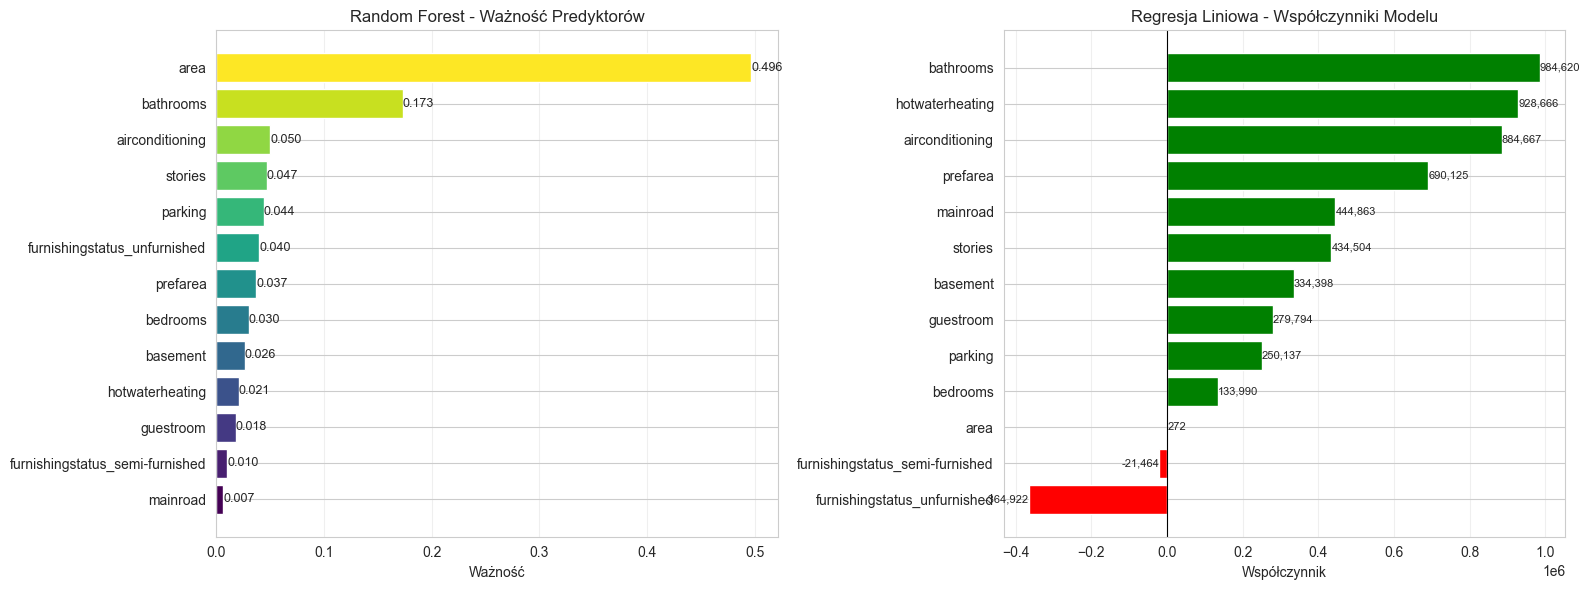


Podsumowanie ważności zmiennych:

RANDOM FOREST (Top 10):
                   Predyktor  Ważność
                        area 0.496462
                   bathrooms 0.173294
             airconditioning 0.049952
                     stories 0.046814
                     parking 0.044305
furnishingstatus_unfurnished 0.039984
                    prefarea 0.037248
                    bedrooms 0.030146
                    basement 0.026272
             hotwaterheating 0.020740


REGRESJA LINIOWA (Top 10 po wartości bezwzględnej):
                   Predyktor   Współczynnik
                   bathrooms  984619.847443
             hotwaterheating  928665.856401
             airconditioning  884667.257243
                    prefarea  690124.883777
                    mainroad  444863.392682
                     stories  434504.322313
furnishingstatus_unfurnished -364921.728648
                    basement  334398.301019
                   guestroom  279793.837226
                     parking 

In [23]:
# Wizualizacja ważności predyktorów
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
ax = axes[0]
feature_imp_sorted = feature_importance_rf.sort_values('Ważność', ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_imp_sorted)))
bars = ax.barh(feature_imp_sorted['Predyktor'], feature_imp_sorted['Ważność'], color=colors)
ax.set_xlabel('Ważność')
ax.set_title('Random Forest - Ważność Predyktorów')
ax.grid(axis='x', alpha=0.3)

# Dodaj wartości na słupkach
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.3f}', 
            ha='left', va='center', fontsize=9)

# Linear Regression Coefficients
ax = axes[1]
coef_sorted = coefficients_lr.sort_values('Współczynnik')
colors_lr = ['red' if x < 0 else 'green' for x in coef_sorted['Współczynnik']]
bars = ax.barh(coef_sorted['Predyktor'], coef_sorted['Współczynnik'], color=colors_lr)
ax.set_xlabel('Współczynnik')
ax.set_title('Regresja Liniowa - Współczynniki Modelu')
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Dodaj wartości na słupkach
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:,.0f}', 
            ha='left' if width > 0 else 'right', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nPodsumowanie ważności zmiennych:")
print("\nRANDOM FOREST (Top 10):")
print(feature_importance_rf.head(10).to_string(index=False))
print("\n\nREGRESJA LINIOWA (Top 10 po wartości bezwzględnej):")
print(coefficients_lr.head(10).to_string(index=False))

## 16. Podsumowanie końcowe

**1. Wczytanie i Czyszczenie Danych** ✓
- Załadowano dataset `Housing.csv` (545 obserwacji, 13 zmiennych)
- Sprawdzono jakość: brak brakujących wartości, brak duplikatów
- Zidentyfikowano outliers (2.75% danych) - pozostawiono
- Ustawiono ziarno: 323535

**2. Eksploracyjna Analiza Danych (EDA)** ✓
- Analiza rozkładu zmiennych (numerycznych i kategorycznych)
- Macierz korelacji - najsilniej korelujące: `area` (0.54), `bathrooms` (0.52)
- Box ploty dla zmiennych kategorycznych vs cena
- Wizualizacja zależności

**3. Dobór Predyktorów** ✓
- **Wybrane zmienne:** area, bedrooms, bathrooms, stories, parking, mainroad, guestroom, basement, airconditioning, prefarea, furnishingstatus, hotwaterheating
- **Razem:** 13 predyktorów

**4. Podział Danych** ✓
- Train: 436 obserwacji (80%)
- Test: 109 obserwacji (20%)
- Random state: 323535

**5. Model 1: Regresja Liniowa** ✓
- **Test R²:** 0.7234 (72.3%)
- **Test RMSE:** 865,010
- **Test MAE:** 660,154
- **Test MAPE:** 15.95%
- Top predyktory: bathrooms (+984k), hotwaterheating (+928k), airconditioning (+884k)

**6. Model 2: Random Forest (Metody Zespołowe)** ✓
- **Test R²:** 0.7094 (70.9%)
- **Test RMSE:** 886,651
- **Test MAE:** 653,525
- **Test MAPE:** 15.45% ← **NAJLEPSZY!**
- Optymalne hiperparametry: `n_estimators`=150, `max_depth`=15, `min_samples_split`=10
- Top predyktory: area (49.6% ważności!), bathrooms (17.3%), airconditioning (5.0%)

**7. Analiza Przeuczenia** ✓
- Regresja Liniowa: **brak przeuczenia** (nawet lepiej na testach)
- Random Forest: **lekkie przeuczenie** (~12% różnica w R²) - normalne, nieproblematyczne

**8. Wykresy Predykcji** ✓
- Scatter ploty: przewidywane vs rzeczywiste
- Wykresy residuów (idealnie rozłożone wokół zera)
- Oba modele wykazują heteroskedastyczność (większe błędy dla wyższych cen)

**9. Wizualizacja Ważności Zmiennych** ✓
- Random Forest: area dominuje (prawie 50% ważności)
- Regresja Liniowa: bathrooms ma największy współczynnik

### WERDYKT:

**Model Zwycięzcy: RANDOM FOREST**

### Dlaczego Random Forest jest lepszy?
Najlepszy MAPE (15.45% vs 15.95%)

Lepszy MAE (653,525 vs 660,154)  

Naturalnie modeluje zależności nieliniowe

Prawidłowo rozpoznaje `area` jako główny predyktor

Lepsza wydajność na wysokich wartościach cen

### Problemy i Spostrzeżenia:
**Heteroskedastyczność** - większe błędy dla wyższych cen (charakterystyczne dla danych finansowych)

**Regresja Liniowa niedoceńia area** - współczynnik zaledwie 272 vs rzeczywista ważność

**Brakujące zmienne** - ~30% wariancji niewyjaśnionej (mogą to być: wiek budynku, precyzyjna lokalizacja, stan techniczny)


---